### Author: Vamsi Tallam
### UIN: 432001932

#### Task 1

1. Create a TfidfVectorizer using the spam files in GP and ham files for kitchen-l and lokay-m from
http://www2.aueb.gr/users/ion/data/enron-spam/
       a. Hints: os.walk is handy. TfidfVectorizer can take a list of filenames. You can ignore
decode errors. I found https://programmerbackpack.com/tf-idf-explained-and-pythonimplementation/ helpful

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
import pickle
import seaborn as sns
import sys
import tarfile
import re
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics

In [37]:
# Fetch the files from .tar.gz files
# open --> extract all --> close

dataset = tarfile.open('GP.tar.gz')
dataset.extractall('./Dataset')
dataset.close()

dataset = tarfile.open('kitchen-l.tar.gz')
dataset.extractall('./Dataset')
dataset.close()

dataset = tarfile.open('lokay-m.tar.gz')
dataset.extractall('./Dataset')
dataset.close()

In [137]:
# TfidfVectorizer can take a list of filenames but this is taking time to load as there are a lot of files.
# Hence, I have chosen to load data using file open. Quicker and more clearer.

# Loading trainig and testing datasets
# We want to create filename and its corresponding content, excluding SKIP_FILES.

# Labels for spam and ham
HAM  = 'notspam'
SPAM = 'spam'

# Path and labels
SOURCES = [ ('/home/vamsi/Desktop/ECEN704/Dataset/GP',        SPAM),
            ('/home/vamsi/Desktop/ECEN704/Dataset/kitchen-l',  HAM),
            ('/home/vamsi/Desktop/ECEN704/Dataset/lokay-m',    HAM) ]

SKIP_FILES = {'cmds'}
SPACE =" "

# To read files 
def load_files(path, TestFlag):
    for root, direc_name, file_names in os.walk(path):
        # temp is a boolean to differentiate train from test
        temp = (root.find('lokay-m')>0 or root.find('part10')>0 or root.find('part11')>0 or root.find('part12')>0)
        if temp == TestFlag:
            #print(root)
            for path in direc_name:
                load_files(os.path.join(root, path), TestFlag)
            for file_name in file_names:
                if file_name not in SKIP_FILES:
                    file_path = os.path.join(root, file_name)
                    if os.path.isfile(file_path):
                        #print(file_path)
                        f = open(file_path, encoding="latin-1") 
                        #Initalize an empty list, read and append each line of the file
                        lines = []
                        for line in f:
                            lines.append(line)
                        #close the file
                        f.close()
                        content = SPACE.join(lines)
                        yield file_path, content

# To build data frame
def build_data_frame(l, path, classification, TestFlag):
    rows = []
    index = []
    for i, (file_name, text) in enumerate(load_files(path, TestFlag)):
        rows.append({'text': text, 'label': classification,'file':file_name})
        index.append(file_name)
   
    data_frame = pd.DataFrame(rows, index=index)
    return data_frame, len(rows)

# To load data, calls upon training and testing data
def load_data(TestFlag):
    #Initialize
    data = pd.DataFrame({'text': [], 'label': [],'file':[]})
    l = 0
    for path, classification in SOURCES:
        data_frame, nrows = build_data_frame(l, path, classification, TestFlag)
        data = data.append(data_frame)
        l += nrows
    # Randomize data for better learning 
    data = data.reindex(np.random.permutation(data.index))
    return data

In [141]:
# To fetch training and testing data; if TestFlag = True then testing data else training data
training_data = load_data(False)
testing_data  = load_data(True)

In [142]:
# To see if we are loading it correctly
training_data.head()
testing_data.head()

,file,label,text
/home/vamsi/Desktop/ECEN704/Dataset/GP/part12/msg3988.eml,/home/vamsi/Desktop/ECEN704/Dataset/GP/part12/...,spam,"From: ""Larry Sharp"" <sharp_fv@asapso.de>\n To:..."
/home/vamsi/Desktop/ECEN704/Dataset/lokay-m/systems/182,/home/vamsi/Desktop/ECEN704/Dataset/lokay-m/sy...,notspam,Message-ID: <24064894.1075860996324.JavaMail.e...
/home/vamsi/Desktop/ECEN704/Dataset/GP/part10/msg1537.eml,/home/vamsi/Desktop/ECEN704/Dataset/GP/part10/...,spam,"From: ""Ilene Hollingsworth"" <chvzwdaw@spray.fr..."
/home/vamsi/Desktop/ECEN704/Dataset/GP/part11/msg2799.eml,/home/vamsi/Desktop/ECEN704/Dataset/GP/part11/...,spam,"From: ""Lowell Lynn"" <hpuwkwibgdtxba@fromru.com..."
/home/vamsi/Desktop/ECEN704/Dataset/GP/part11/msg2455.eml,/home/vamsi/Desktop/ECEN704/Dataset/GP/part11/...,spam,"From: ""Darla Avery"" <carolinejil@iamwasted.com..."


In [143]:
# Removing unnecessary columns and changing labels from spam,ham to 1,0
Testingdata  = testing_data[["text", "label"]]
Trainingdata = training_data[["text","label"]]

Testingdata  = Testingdata.reset_index(drop=True)
Trainingdata = Trainingdata.reset_index(drop=True)

Testingdata['label']  = Testingdata['label'].map({'spam':1, 'notspam':0})
Trainingdata['label'] = Trainingdata['label'].map({'spam':1, 'notspam':0})

In [145]:
Testingdata.head()

,text,label
0,"From: ""Larry Sharp"" <sharp_fv@asapso.de>\n To:...",1
1,Message-ID: <24064894.1075860996324.JavaMail.e...,0
2,"From: ""Ilene Hollingsworth"" <chvzwdaw@spray.fr...",1
3,"From: ""Lowell Lynn"" <hpuwkwibgdtxba@fromru.com...",1
4,"From: ""Darla Avery"" <carolinejil@iamwasted.com...",1


In [144]:
# Extracting data and labels
Xtrain = Trainingdata['text'].values
Ytrain = Trainingdata['label'].values
Xtest  = Testingdata['text'].values
Ytest  = Testingdata['label'].values

In [146]:
numtraining = Xtrain.shape[0]
numtesting = Xtest.shape[0]
print(numtraining)
print(numtesting)
totaldata = np.concatenate((Xtrain, Xtest))
print(totaldata.shape)

14308
5787
(20095,)


In [148]:
# Not using any stopwords and not removing html tags
vectorizer = TfidfVectorizer()
BigMatrix = vectorizer.fit_transform(totaldata)

#### End of Task 1

#### Task 2

Use a pandas DataFrame to look at the top 25 words in one spam message and the top 25 words
in one ham message

In [153]:
# The first row is an extract from a spam mail and the second row is an extract from a ham mail
# it is a sparse vector, we can remove 0s and sort it to print top 25 
feature_names = vectorizer.get_feature_names()
temp_spam = pd.DataFrame(BigMatrix[0].T.todense(), index = feature_names)
temp_spam.columns = ['tfidf_values']
temp_spam.sort_values(by = 'tfidf_values', ascending = False).head(25).T

,a0,armor,electric,arme,and,vehicle,of,vehicles,the,enterprises,...,in,ev,major,to,distribution,20,atv,scooters,technologies,with
tfidf_values,0.538795,0.284842,0.269967,0.206958,0.205763,0.178731,0.161169,0.159211,0.155595,0.146251,...,0.087839,0.086129,0.078345,0.075408,0.074811,0.074722,0.069569,0.066808,0.066668,0.064065


In [154]:
# The first row is an extract from a spam mail and the second row is an extract from a ham mail
# it is a sparse vector, we can remove 0s and sort it to print top 25 

temp_ham = pd.DataFrame(BigMatrix[1].T.todense(), index = feature_names)
temp_ham.columns = ['tfidf_values']
temp_ham.sort_values(by = 'tfidf_values', ascending = False).head(25).T

,onondaga,the,ben,receivable,jacoby,million,asset,that,payment,to,...,of,internal,agreement,income,duran,billy,our,down,will,oclp
tfidf_values,0.391533,0.316749,0.223213,0.182196,0.179114,0.144877,0.140787,0.139326,0.132205,0.128668,...,0.10859,0.104132,0.102134,0.101641,0.101265,0.097407,0.095307,0.095163,0.094238,0.093628


#### End of Task 2

#### Task 3 and Task 4

Train a RandomForestClassifier using the parts 1-9 spam emails and kitchen-l ham emails.

Using your RandomForestClassifier, predict the emails in GP parts 10-12 and lokay-m. Display
the number of true positive (spam), false positive, true negative (ham) and false negatives.

In [155]:
# Split the training and testing data
finaltrain = BigMatrix[0:numtraining, :]
finaltest = BigMatrix[numtraining:BigMatrix.shape[0],:]

In [156]:
# To check if we split the data correctly
print(finaltrain.shape)
print(finaltest.shape)

(14308, 413456)
(5787, 413456)


In [159]:
# Building a Random Forest Classifier
RFC = RandomForestClassifier(n_estimators=20)
model= RFC.fit(finaltrain, Ytrain)
pred = RFC.predict(finaltest)

# Calculate the accuracy on the test data.
print("Accuracy: {}".format(RFC.score(finaltest, Ytest)))

Accuracy: 1.0


             precision    recall  f1-score   support

       Spam       1.00      1.00      1.00      2364
        Ham       1.00      1.00      1.00      3423

avg / total       1.00      1.00      1.00      5787



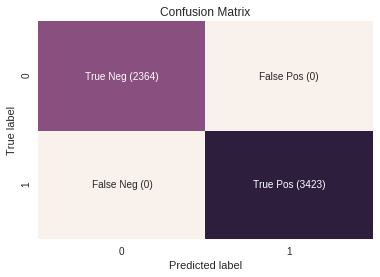

In [163]:
# To generate classification report
print(metrics.classification_report(Ytest, pred,target_names=['Spam','Ham']))

# To build the confusion matrix
cm = confusion_matrix(Ytest, pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
annotations = [f"{v1} ({v2})" for v1, v2 in zip(labels, cm.flatten())]
annotations = np.asarray(annotations).reshape(2,2)
sns.heatmap(cm, annot=annotations, fmt='', cbar = False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")

We can see 100% accuracy on test data 

#### End of Task 3 and Task 4

#### Task 5

In the second half of your Jupyter notebook (i.e. don’t change your code above, add more), redo the steps above using a stopwords list containing “enron” and HTML tags. Again, predict the emails in GP parts 10-12 and lokay-m.

Display the number of true positive (spam), false positive, true negative (ham) and false
negatives.

I created a stopwords list using: https://raw.githubusercontent.com/stopwords-
iso/stopwords-en/master/stopwords-en.txt and https://techspirited.com/all-html-tags-
list-of-all-html-tags

In [172]:
# To fetch stopwords
import urllib
url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt"

stop_words_file = urllib.request.urlopen(url)

stopwords = {'enron'}
for line in stop_words_file:
    stopwords.add(line.decode("utf-8").strip())

#to see the stop words
#print(stopwords)

In [171]:
# To remove html tags, url linking and cleaning
def clean_messages(message):
    # To url linking
    message = re.sub(r'http\S+', ' ', message)
    message = re.sub("\d+", " ", message)
    message = message.replace('\n', ' ')
    # To remove html tags
    message = message.translate(str.maketrans("", "", punctuation))
    soup = BeautifulSoup(message, "html.parser")
    message = soup.get_text()
    message = message.lower()
    
    return message

In [175]:
Trainingdata['clean_text'] = Trainingdata['text'].apply(clean_messages)
Testingdata['clean_text'] = Testingdata['text'].apply(clean_messages)

In [176]:
# Extracting data and labels
Xtrain_new = Trainingdata['clean_text'].values
Ytrain_new = Trainingdata['label'].values
Xtest_new  = Testingdata['clean_text'].values
Ytest_new  = Testingdata['label'].values

In [177]:
totaldata_new = np.concatenate((Xtrain_new, Xtest_new))

In [178]:
##stop_word_set = {"enron"}
vectorizer = TfidfVectorizer(stop_words= stop_words_list)
BigMatrix_new= vectorizer.fit_transform(totaldata_new)

In [179]:
# The first row is an extract from a spam mail and the second row is an extract from a ham mail
# it is a sparse vector, we can remove 0s and sort it to print top 25 
feature_names = vectorizer.get_feature_names()
temp_spam = pd.DataFrame(BigMatrix_new[0].T.todense(), index = feature_names)
temp_spam.columns = ['tfidf_values']
temp_spam.sort_values(by = 'tfidf_values', ascending = False).head(25).T

,electric,armor,vehicle,arme,vehicles,enterprises,battery,major,atvs,barmor,...,rapidly,ev,board,drive,strategic,marine,industry,craft,revenues,gokart
tfidf_values,0.411894,0.30439,0.249457,0.2477,0.239834,0.235001,0.151322,0.118271,0.104081,0.104081,...,0.083266,0.082788,0.080938,0.079537,0.074552,0.072587,0.072551,0.072134,0.069998,0.069388


In [180]:
# The first row is an extract from a spam mail and the second row is an extract from a ham mail
# it is a sparse vector, we can remove 0s and sort it to print top 25 

temp_ham = pd.DataFrame(BigMatrix_new[1].T.todense(), index = feature_names)
temp_ham.columns = ['tfidf_values']
temp_ham.sort_values(by = 'tfidf_values', ascending = False).head(25).T

,onondaga,ben,receivable,jacoby,asset,payment,received,valuation,accounting,internal,...,support,original,prior,louise,duran,cashflow,gain,fleenor,mtm,adjustment
tfidf_values,0.513656,0.258627,0.23671,0.194938,0.184192,0.178911,0.15739,0.155317,0.153276,0.135967,...,0.104414,0.103791,0.103202,0.099909,0.099703,0.098344,0.09654,0.091845,0.091225,0.085866


You can see the difference after removing the stop words

In [182]:
# Split the training and testing data
finaltrain_new = BigMatrix_new[0:numtraining, :]
finaltest_new = BigMatrix_new[numtraining:BigMatrix_new.shape[0],:]

# To check if we split the data correctly
print(finaltrain_new.shape)
print(finaltest_new.shape)

(14308, 636672)
(5787, 636672)


In [188]:
# Building a Random Forest Classifier
RFC = RandomForestClassifier(n_estimators=20)
model_new= RFC.fit(finaltrain_new, Ytrain)
pred = RFC.predict(finaltest_new)

# Calculate the accuracy on the test data.
print("Accuracy: {}".format(RFC.score(finaltest_new, Ytest)))

# To generate classification report
print(metrics.classification_report(Ytest, pred,target_names=['Spam','Ham']))

Accuracy: 1.0
             precision    recall  f1-score   support

       Spam       1.00      1.00      1.00      2364
        Ham       1.00      1.00      1.00      3423

avg / total       1.00      1.00      1.00      5787



In [189]:
# For 20 estimators we see a 100% accuracy so reducing them
RFC = RandomForestClassifier(n_estimators=10)
model_new= RFC.fit(finaltrain_new, Ytrain)
pred = RFC.predict(finaltest_new)

# Calculate the accuracy on the test data.
print("Accuracy: {}".format(RFC.score(finaltest_new, Ytest)))

# To generate classification report
print(metrics.classification_report(Ytest, pred,target_names=['Spam','Ham']))

Accuracy: 0.9998271988940729
             precision    recall  f1-score   support

       Spam       1.00      1.00      1.00      2364
        Ham       1.00      1.00      1.00      3423

avg / total       1.00      1.00      1.00      5787



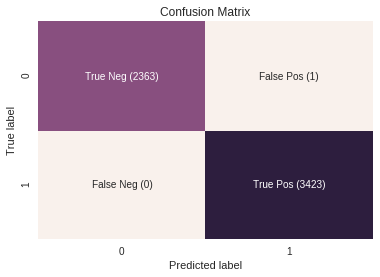

In [190]:
# To build the confusion matrix
cm = confusion_matrix(Ytest, pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
annotations = [f"{v1} ({v2})" for v1, v2 in zip(labels, cm.flatten())]
annotations = np.asarray(annotations).reshape(2,2)
sns.heatmap(cm, annot=annotations, fmt='', cbar = False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")

Using 10 estimators we get 99.982% accuracy (1 misclassification).

#### End of part 5